# Task 1 - Text classification

The results in the this notebook are not "expected". This is because the size of the data was extremely reduced to compute all the batches fed to MBERT to generate the embeddings. With a time and computational resources, this approach would work better. But the aim of this notebook is to show another viable approach to address the same task.

### 1) Load libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import sys
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn import svm

### 2) Read the csv

This csv is the output from the notebook run in Google Colab.

The word embedding is flatten, generating as many columns as the length of the vector (512).

In [2]:
df_f= pd.read_csv('ea_embeddings_bert_flatten_good.csv', sep=',', header=0)

In [3]:
df_f.head()

,language,category,2,3,4,5,6,7,8,9,...,6904,6905,6906,6907,6908,6909,6910,6911,6912,6913
0,en,APR,0.214127,-0.255636,0.392288,-0.109920,-0.026097,0.148366,0.293664,0.275959,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,en,APR,0.215509,-0.325457,0.332228,-0.287824,-0.136689,0.383519,0.291183,0.286996,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,en,APR,0.026788,-0.305175,0.072571,-0.581912,-0.353657,-0.348442,0.470672,-0.131022,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,en,APR,0.167107,-0.194416,0.234103,-0.311199,-0.171992,0.159504,0.265455,0.096494,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,en,APR,0.350445,-0.230253,0.319622,-0.219304,-0.079355,0.508322,0.284624,0.340958,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


One hot encoding of categorical variables.

In [4]:
# use pd.concat to join the new columns with your original dataframe
df_f = pd.concat([df_f,pd.get_dummies(df_f['language'], prefix='language')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
df_f.drop(['language'],axis=1, inplace=True)

In [5]:
df_f.head()

,category,2,3,4,5,6,7,8,9,10,...,6907,6908,6909,6910,6911,6912,6913,language_en,language_es,language_fr
0,APR,0.214127,-0.255636,0.392288,-0.109920,-0.026097,0.148366,0.293664,0.275959,-0.319734,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
1,APR,0.215509,-0.325457,0.332228,-0.287824,-0.136689,0.383519,0.291183,0.286996,-0.481386,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
2,APR,0.026788,-0.305175,0.072571,-0.581912,-0.353657,-0.348442,0.470672,-0.131022,0.239081,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
3,APR,0.167107,-0.194416,0.234103,-0.311199,-0.171992,0.159504,0.265455,0.096494,-0.173541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0
4,APR,0.350445,-0.230253,0.319622,-0.219304,-0.079355,0.508322,0.284624,0.340958,-0.570853,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0


In [9]:
df_f=df_f.dropna(axis=1,how='any')

In [10]:
df_f.head()

,category,2,3,4,5,6,7,8,9,10,...,763,764,765,766,767,768,769,language_en,language_es,language_fr
0,APR,0.214127,-0.255636,0.392288,-0.109920,-0.026097,0.148366,0.293664,0.275959,-0.319734,...,0.760154,0.236110,0.069117,0.286525,-0.237154,0.210623,0.166840,1,0,0
1,APR,0.215509,-0.325457,0.332228,-0.287824,-0.136689,0.383519,0.291183,0.286996,-0.481386,...,0.915986,0.330213,0.350417,0.210346,-0.446477,0.363072,0.322220,1,0,0
2,APR,0.026788,-0.305175,0.072571,-0.581912,-0.353657,-0.348442,0.470672,-0.131022,0.239081,...,0.990188,0.018095,-0.012594,-0.209171,-0.475615,0.182417,0.382166,1,0,0
3,APR,0.167107,-0.194416,0.234103,-0.311199,-0.171992,0.159504,0.265455,0.096494,-0.173541,...,0.918594,0.261794,0.163606,0.017038,-0.231260,0.300026,0.318531,1,0,0
4,APR,0.350445,-0.230253,0.319622,-0.219304,-0.079355,0.508322,0.284624,0.340958,-0.570853,...,0.939394,0.363611,0.347100,0.305120,-0.490583,0.399251,0.338498,1,0,0


We separate the feature vector and the label in two different dataframes.

In [11]:
df_label = df_f['category']
df_features = df_f.drop(columns=['category'])

We split the dataset into training (90%) and test (10%). With the stratify function, it is ensure that there is a good proportion of the 4 labels in both sets. The percetanges are changed because now we have less data (we trimmed it to reduce the computation times).

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_features, df_label, stratify=df_label, test_size=0.1)

We train a classifier an we are going to start with a very basic as Logistic Regression model, because sometimes the simpler the better. There are also other reasons for that, for example, not all the languages have text in all categories, so it is easy to discard a language in some categories, reducing the problem to a kind of "binary" classification.

In [13]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
score = lr.score(X_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

print(metrics.classification_report(y_test, y_pred))

0.9961783439490446
[[214   0   0   0]
 [  0  21   0   0]
 [  2   0  95   0]
 [  1   0   0 452]]
                   precision    recall  f1-score   support

              APR       0.99      1.00      0.99       214
Conference_papers       1.00      1.00      1.00        21
            PAN11       1.00      0.98      0.99        97
        Wikipedia       1.00      1.00      1.00       453

         accuracy                           1.00       785
        macro avg       1.00      0.99      1.00       785
     weighted avg       1.00      1.00      1.00       785



D:\Anaconda\envs\tf2_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [14]:
print(y_test[0:10])
print(y_pred[0:10])

7273            Wikipedia
7182            Wikipedia
4424            Wikipedia
1130                  APR
6747            Wikipedia
5293            Wikipedia
6141            Wikipedia
2328    Conference_papers
1057                  APR
3567            Wikipedia
Name: category, dtype: object
['Wikipedia' 'Wikipedia' 'Wikipedia' 'APR' 'Wikipedia' 'Wikipedia'
 'Wikipedia' 'Conference_papers' 'APR' 'Wikipedia']


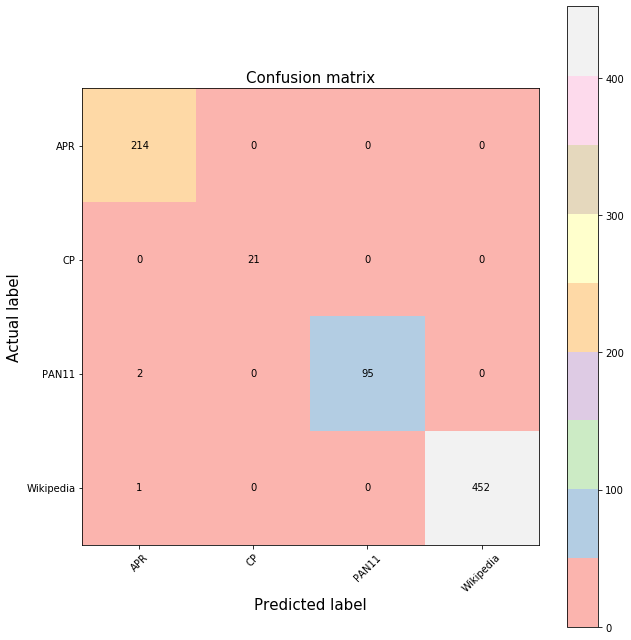

In [15]:
plt.figure(figsize=(9,9))
plt.imshow(cm, interpolation='nearest', cmap='Pastel1')
plt.title('Confusion matrix', size = 15)
plt.colorbar()
tick_marks = np.arange(4)
plt.xticks(tick_marks, ["APR", "CP", "PAN11", "Wikipedia"], rotation=45, size = 10)
plt.yticks(tick_marks, ["APR", "CP", "PAN11", "Wikipedia"], size = 10)
plt.tight_layout()
plt.ylabel('Actual label', size = 15)
plt.xlabel('Predicted label', size = 15)
width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y, x), 
        horizontalalignment='center',
        verticalalignment='center')

The resuts are not good. Wikipedia is the only label classified.

In [16]:
svm_cl = svm.SVC(kernel='linear')
svm_cl.fit(X_train, y_train)
y_pred = svm_cl.predict(X_test)

score = svm_cl.score(X_test, y_test)
print(score)

cm = metrics.confusion_matrix(y_test, y_pred)
print(cm)

print(metrics.classification_report(y_test, y_pred))

0.9910828025477707
[[212   0   2   0]
 [  0  20   0   1]
 [  2   0  95   0]
 [  1   0   1 451]]
                   precision    recall  f1-score   support

              APR       0.99      0.99      0.99       214
Conference_papers       1.00      0.95      0.98        21
            PAN11       0.97      0.98      0.97        97
        Wikipedia       1.00      1.00      1.00       453

         accuracy                           0.99       785
        macro avg       0.99      0.98      0.98       785
     weighted avg       0.99      0.99      0.99       785



The results are the same with a more complex model, lets try to apply Cross Validation to separate the data split influence in the behaviour.

In [17]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

In [18]:
accuracies = []

for train_index, test_index in kf.split(df_label):

    data_train   = df_features.loc[train_index]
    target_train = df_label.loc[train_index]

    data_test    = df_features.loc[test_index]
    target_test  = df_label.loc[test_index]

    # if needed, do preprocessing here

    clf = LogisticRegression()
    clf.fit(data_train,target_train)

    preds = clf.predict(data_test)

    # accuracy for the current fold only    
    accuracy = metrics.accuracy_score(target_test,preds)

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

D:\Anaconda\envs\tf2_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
D:\Anaconda\envs\tf2_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

In [19]:
print(accuracies)
print(average_accuracy)

[0.9904458598726115, 0.9859872611464968, 0.9834289356277884, 0.9904397705544933, 0.9904397705544933]
0.9881483195511767


At the end, the results are similar. It happens because the documents were trimmed too much, and the number of documents was reduced. It was done just to show the viability of another technique to solve the problem, but the lack of time and computational resources pushed to reduce the data to deliver this approach.